<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


# Funciones

In [2]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [3]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N_202207.csv'

datos = pd.read_csv(file, index_col = [0], parse_dates=['DATE'])
datos = datos.loc['2000-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-03-01,102.7847
2022-04-01,91.4572
2022-05-01,93.8530


revisamos si las fechas están ordenadas

In [4]:
# La monotonicidad es una propiedad matemática que indica que una función 
# determinada mantiene un orden no creciente o decreciente en todo su dominio


datos.index.is_monotonic_increasing

True

In [5]:
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='DATE', length=271, freq=None)

In [6]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='DATE', length=271, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

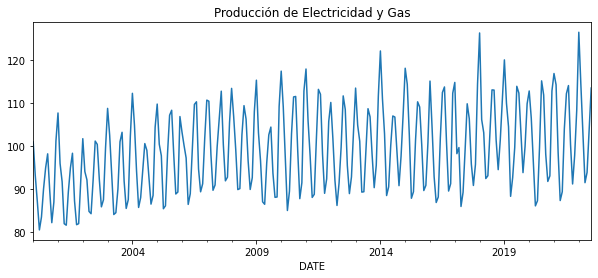

In [7]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

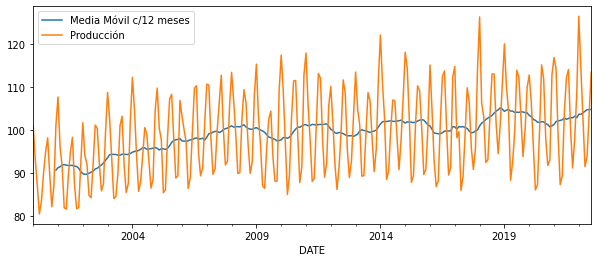

In [ ]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

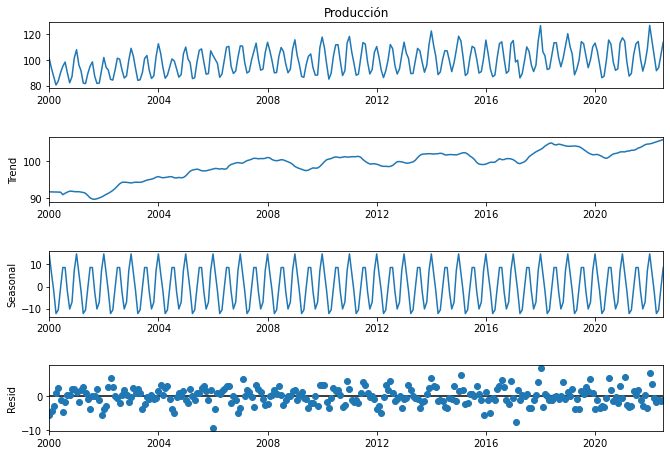

In [ ]:
decomp = seasonal_decompose(datos['Producción']
                            , period=12, extrapolate_trend='freq'
                            )
fig =decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [8]:
pValue = adfuller(datos['Producción'])[1]
pValue

0.41398340161359953

In [9]:
p_value_adfuller(datos['Producción'])

P-value:  0.41398340161359953
No se rechaza la hipóteis nula, los datos no son estacionarios


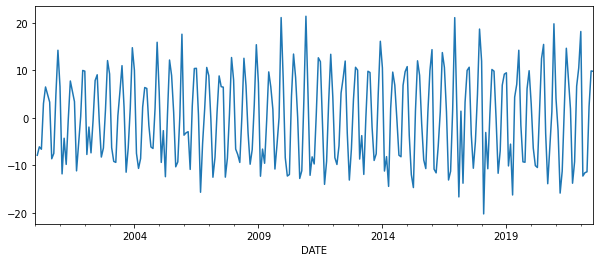

In [10]:
datos['1a diff']= datos['Producción'] - datos['Producción'].shift(1)  
datos['1a diff'].plot(figsize=(10,4))
plt.show()

In [11]:
datos.head()

,Producción,1a diff
DATE,,
2000-01-01,100.9623,NaN
2000-02-01,93.1065,-7.8558
2000-03-01,87.0234,-6.0831
2000-04-01,80.4433,-6.5801
2000-05-01,83.4549,3.0116


In [12]:
p_value_adfuller(datos['1a diff'].dropna())

P-value:  7.413187409341447e-14
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

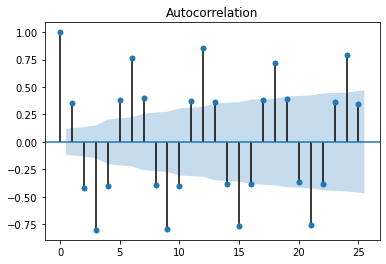

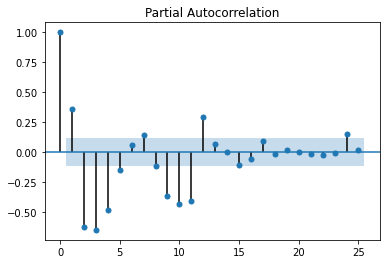

In [13]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [ ]:
datos.index.min(), datos.index.max()

(Timestamp('2000-01-01 00:00:00', freq='MS'),
 Timestamp('2022-07-01 00:00:00', freq='MS'))

In [14]:
train = datos.loc[:'2021-07-01','Producción']
test = datos.loc['2021-07-01':,'Producción']

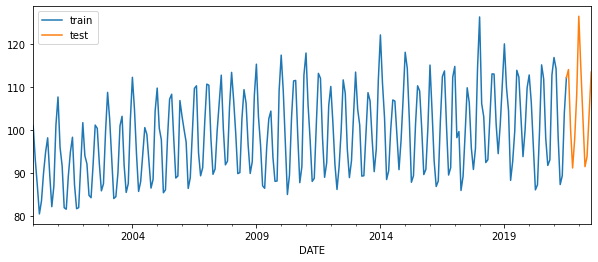

In [15]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [16]:
p =  q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [17]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [18]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(train,
                       order = parametros,             # p, q, d
                       seasonal_order = parametros_s,  # p, q, d  de la temporalidad
                       enforce_stationarity = False,   
                       enforce_invertibility = False   # permite que el polinomio de promedio móvil no sea invertible, 
                                                       # de modo que la mayoría de los modelos sean estimables.
                       )                  
      results = modelo.fit(method_kwargs={"warn_convergence": False})
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:1865.209920266946
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:1604.1675446017855
ARIMA(0, 1, 0) x (0, 0, 2, 12) - AIC:1454.6464013986708
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:1370.5862179224378
ARIMA(0, 1, 0) x (0, 1, 1, 12) - AIC:1228.5083664825274
ARIMA(0, 1, 0) x (0, 1, 2, 12) - AIC:1166.7471513640023
ARIMA(0, 1, 0) x (0, 2, 0, 12) - AIC:1526.0616211369345
ARIMA(0, 1, 0) x (0, 2, 1, 12) - AIC:1280.992970040287
ARIMA(0, 1, 0) x (0, 2, 2, 12) - AIC:1158.058110415383
ARIMA(0, 1, 0) x (1, 0, 0, 12) - AIC:1370.0629715057412
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:1284.6251289851052
ARIMA(0, 1, 0) x (1, 0, 2, 12) - AIC:1222.6844412713367
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:1294.3938320845316
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC:1230.495218408858
ARIMA(0, 1, 0) x (1, 1, 2, 12) - AIC:1167.0555455011859
ARIMA(0, 1, 0) x (1, 2, 0, 12) - AIC:1387.8403884570075
ARIMA(0, 1, 0) x (1, 2, 1, 12) - AIC:1270.332141384392
ARIMA(0, 1, 0) x (1, 2, 2, 12) - AIC:1171.86895818129

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 0, 2, 12) - AIC:1153.3181473302106
ARIMA(1, 1, 2) x (2, 1, 0, 12) - AIC:1143.1535857211643
ARIMA(1, 1, 2) x (2, 1, 1, 12) - AIC:1106.1503034315815
ARIMA(1, 1, 2) x (2, 1, 2, 12) - AIC:1093.7516629999395
ARIMA(1, 1, 2) x (2, 2, 0, 12) - AIC:1217.3564082964167
ARIMA(1, 1, 2) x (2, 2, 1, 12) - AIC:1128.474443991733
ARIMA(1, 1, 2) x (2, 2, 2, 12) - AIC:1099.076527917848
ARIMA(2, 1, 0) x (0, 0, 0, 12) - AIC:1696.9206248200303
ARIMA(2, 1, 0) x (0, 0, 1, 12) - AIC:1535.4309783663875
ARIMA(2, 1, 0) x (0, 0, 2, 12) - AIC:1417.3115376438345
ARIMA(2, 1, 0) x (0, 1, 0, 12) - AIC:1331.574746610221
ARIMA(2, 1, 0) x (0, 1, 1, 12) - AIC:1200.5816005460342
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC:1137.198553222846
ARIMA(2, 1, 0) x (0, 2, 0, 12) - AIC:1482.7137009368553
ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC:1246.874875273222
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC:1128.9653138662652
ARIMA(2, 1, 0) x (1, 0, 0, 12) - AIC:1329.217308445899
ARIMA(2, 1, 0) x (1, 0, 1, 12) - AIC:1248.075511452146

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC:1464.3102706858901
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC:1217.52712209434
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC:1098.5326978536582
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC:1299.8544220162228
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC:1222.9473026324595
ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC:1163.2683545956436
ARIMA(2, 1, 1) x (1, 1, 0, 12) - AIC:1227.5499591173605
ARIMA(2, 1, 1) x (1, 1, 1, 12) - AIC:1167.8178629818615
ARIMA(2, 1, 1) x (1, 1, 2, 12) - AIC:1105.4466224808898
ARIMA(2, 1, 1) x (1, 2, 0, 12) - AIC:1342.6625093152256
ARIMA(2, 1, 1) x (1, 2, 1, 12) - AIC:1211.0452633112568
ARIMA(2, 1, 1) x (1, 2, 2, 12) - AIC:1100.5325427415005
ARIMA(2, 1, 1) x (2, 0, 0, 12) - AIC:1226.040197929563
ARIMA(2, 1, 1) x (2, 0, 1, 12) - AIC:1170.489531861457
ARIMA(2, 1, 1) x (2, 0, 2, 12) - AIC:1156.6533191395047
ARIMA(2, 1, 1) x (2, 1, 0, 12) - AIC:1136.7128139829874
ARIMA(2, 1, 1) x (2, 1, 1, 12) - AIC:1098.5977992765493
ARIMA(2, 1, 1) x (2, 1, 2, 12) - AIC:1100.5633531678

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 0, 1, 12) - AIC:1314.894132450694


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (0, 0, 2, 12) - AIC:1250.5592834416661
ARIMA(2, 1, 2) x (0, 1, 0, 12) - AIC:1304.0577689024926
ARIMA(2, 1, 2) x (0, 1, 1, 12) - AIC:1161.80797899842
ARIMA(2, 1, 2) x (0, 1, 2, 12) - AIC:1104.8437878231339
ARIMA(2, 1, 2) x (0, 2, 0, 12) - AIC:1452.53992813465
ARIMA(2, 1, 2) x (0, 2, 1, 12) - AIC:1213.223811711097
ARIMA(2, 1, 2) x (0, 2, 2, 12) - AIC:1094.7959881624097
ARIMA(2, 1, 2) x (1, 0, 0, 12) - AIC:1301.3628481105845
ARIMA(2, 1, 2) x (1, 0, 1, 12) - AIC:1220.189270100077


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC:1161.1396490163652
ARIMA(2, 1, 2) x (1, 1, 0, 12) - AIC:1229.8178779077766


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC:1163.92081354772
ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC:1103.000785380801
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC:1323.0226745826612
ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC:1206.8847349442972


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC:1098.5122464408232
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC:1228.0158251325688
ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC:1172.4894156389041


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC:1154.2847999847256
ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC:1138.6153659188376
ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC:1100.5812818653399
ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC:1095.638346907911
ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC:1213.7738081027403
ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC:1125.1925541825876


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 2, 2, 12) - AIC:1100.2315977382777


El criterio de información de Akaike ([AIC](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_de_Akaike)) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

Considera la bondad de ajuste del modelo a los datos, pero también la complejidad del modelo (número de parámetros)

AIC ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos

In [19]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 2), (0, 2, 2, 12))
AIC:  1093.3524444115285


In [20]:
modelo = SARIMAX(train,
                 order = (1, 1, 2),
                 seasonal_order = (0, 2, 2, 12),
                 enforce_stationarity = False,
                 enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5246      0.201      2.611      0.009       0.131       0.918
ma.L1         -1.0993      0.227     -4.853      0.000      -1.543      -0.655
ma.L2          0.1444      0.196      0.739      0.460      -0.239       0.528
ma.S.L12      -1.9850    441.871     -0.004      0.996    -868.037     864.067
ma.S.L24       1.0001    445.288      0.002      0.998    -871.748     873.749
sigma2         7.6602   3410.460      0.002      0.998   -6676.719    6692.039


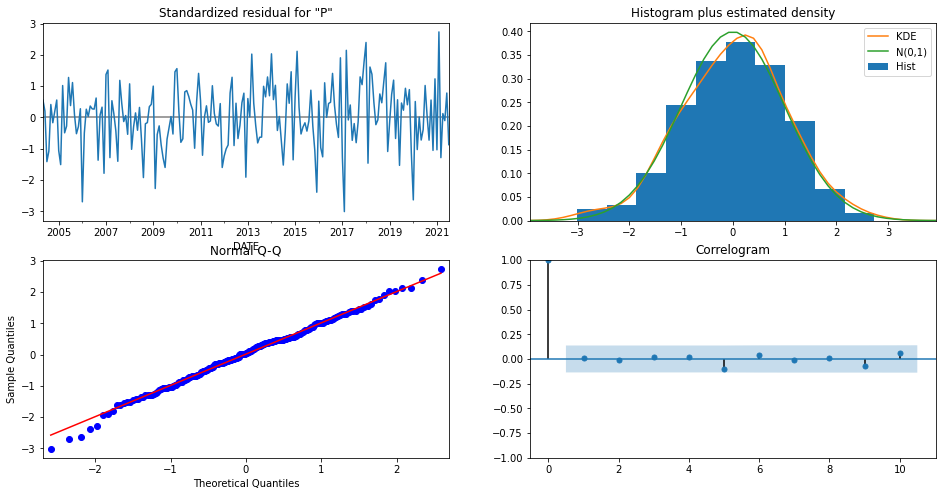

In [21]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

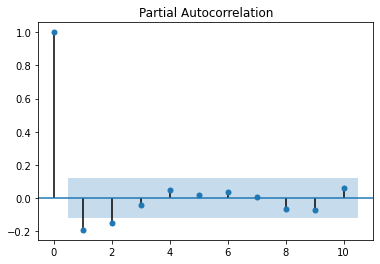

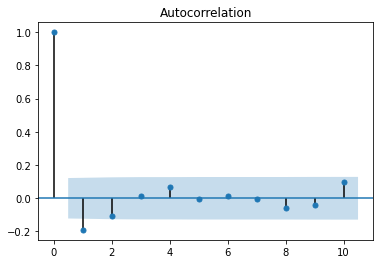

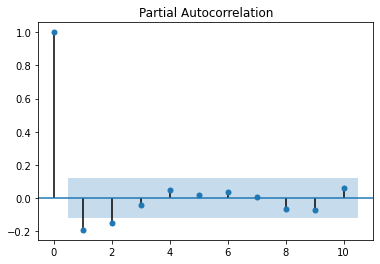

In [22]:
resultados.resid
plot_acf(resultados.resid, lags=10)
plot_pacf(resultados.resid, lags=10)

# Validación

In [24]:
pred = resultados.get_prediction(start=pd.to_datetime('2021-07-01'),
                                 end=pd.to_datetime('2022-07-01'),)
pred.predicted_mean

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2021-07-01    114.749436
2021-08-01    110.800287
2021-09-01     99.310787
2021-10-01     90.621458
2021-11-01     95.504905
2021-12-01    110.652049
2022-01-01    118.949621
2022-02-01    107.783777
2022-03-01     99.073072
2022-04-01     86.425851
2022-05-01     88.992787
2022-06-01    101.655430
2022-07-01    113.538514
Freq: MS, Name: predicted_mean, dtype: float64

In [25]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
2021-07-01,109.003141,120.495732
2021-08-01,105.055096,116.545479
2021-09-01,93.061638,105.559935
2021-10-01,84.180989,97.061927
2021-11-01,88.974151,102.035659
2021-12-01,104.068817,117.235282
2022-01-01,112.329776,125.569466
2022-02-01,101.137544,114.430009
2022-03-01,92.404878,105.741266
2022-04-01,79.729970,93.121733


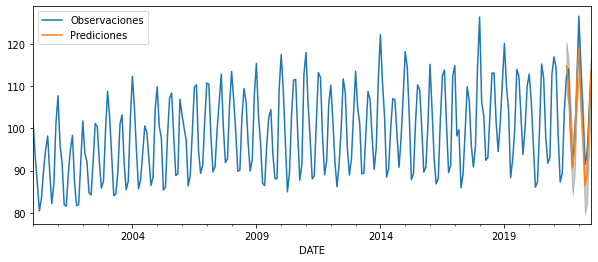

In [26]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

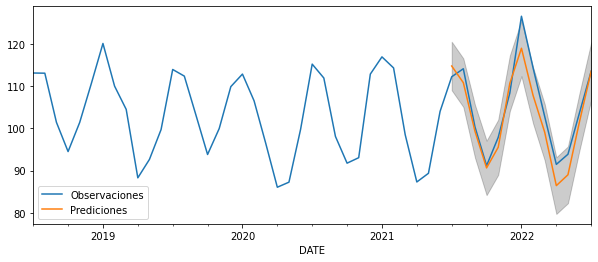

In [27]:
fig = datos.loc['2018-07-01':,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [29]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2021-07-01':'2022-07-01','Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 15.12
La raiz del error cuadrático medio es 3.89
